In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
# Load datasets
vix_df = pd.read_csv("./CBOE VIX.csv")
sharpe_ratios_df = pd.read_csv("./Sharpe Ratios for S&P 500 Co.csv")
risk_ratings_df = pd.read_csv("./SP 500 ESG Risk Ratings.csv")

In [99]:
import pandas as pd
import statsmodels.formula.api as smf

# Make a copy of your final dataset
df = final_timeseries.copy()

# Drop rows with missing values to ensure the regression runs smoothly
df = df.dropna(subset=['Sharpe Ratio', 'Close', 'Total ESG Risk score'])

# Fit a linear regression with interaction: 
# Sharpe Ratio ~ VIX + ESG + (VIX * ESG)
model = smf.ols("Q('Sharpe Ratio') ~ Q('Close') * Q('Total ESG Risk score')", data=df).fit()

# Print the summary to see coefficients, p-values, and R-squared
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Q('Sharpe Ratio')   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     54.71
Date:                Fri, 07 Mar 2025   Prob (F-statistic):           4.77e-35
Time:                        22:32:16   Log-Likelihood:                 1705.9
No. Observations:                9262   AIC:                            -3404.
Df Residuals:                    9258   BIC:                            -3375.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [100]:
import pandas as pd
import numpy as np

# Make a copy to avoid altering the original DataFrame
df = final_timeseries.copy()

# 1. Create bins for VIX. Here we split into four quartiles (Low, Med-Low, Med-High, High).
# You can adjust the number of bins or the labels as you see fit.
df['VIX_bin'] = pd.qcut(df['Close'], q=4, labels=['Low Vol','Med-Low Vol','Med-High Vol','High Vol'])

# 2. Group by Sector and the new VIX_bin
grouped = df.groupby(['Sector', 'VIX_bin'])

for (sector, vol_bin), group_data in grouped:
    # Compute correlation between Sharpe Ratio and ESG in this subset
    corr_value = group_data[['Sharpe Ratio', 'Total ESG Risk score']].corr().iloc[0,1]
    
    print(f"Sector: {sector} | Volatility Bin: {vol_bin} | Correlation (Sharpe vs ESG): {corr_value:.2f}")


Sector: Basic Materials | Volatility Bin: Low Vol | Correlation (Sharpe vs ESG): -0.24
Sector: Basic Materials | Volatility Bin: Med-Low Vol | Correlation (Sharpe vs ESG): -0.23
Sector: Basic Materials | Volatility Bin: Med-High Vol | Correlation (Sharpe vs ESG): -0.23
Sector: Basic Materials | Volatility Bin: High Vol | Correlation (Sharpe vs ESG): -0.31
Sector: Communication Services | Volatility Bin: Low Vol | Correlation (Sharpe vs ESG): 0.56
Sector: Communication Services | Volatility Bin: Med-Low Vol | Correlation (Sharpe vs ESG): 0.51
Sector: Communication Services | Volatility Bin: Med-High Vol | Correlation (Sharpe vs ESG): 0.55
Sector: Communication Services | Volatility Bin: High Vol | Correlation (Sharpe vs ESG): 0.58
Sector: Consumer Cyclical | Volatility Bin: Low Vol | Correlation (Sharpe vs ESG): -0.13
Sector: Consumer Cyclical | Volatility Bin: Med-Low Vol | Correlation (Sharpe vs ESG): -0.15
Sector: Consumer Cyclical | Volatility Bin: Med-High Vol | Correlation (Sharpe

/var/folders/40/s6qykty12fdcmr7sw5h2nvz00000gn/T/ipykernel_5839/717876849.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Sector', 'VIX_bin'])


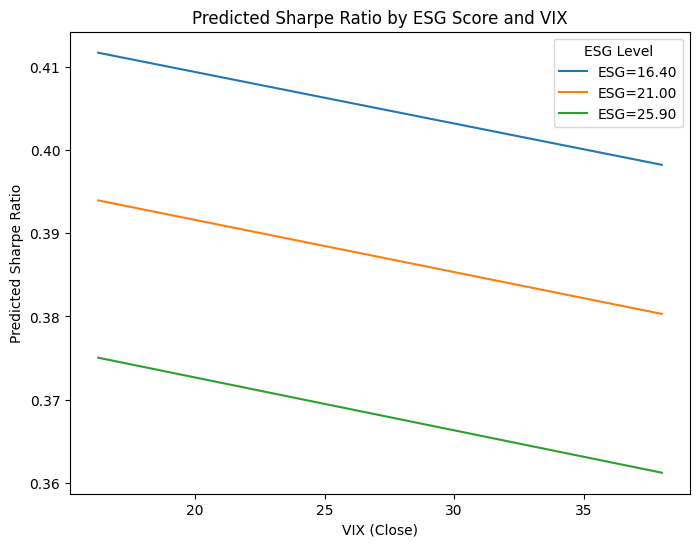

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of values for VIX (Close) and pick a few representative ESG scores
vix_range = np.linspace(df['Close'].min(), df['Close'].max(), 50)

# For illustration, let's use three ESG levels: 25th, 50th, and 75th percentiles
esg_levels = [
    df['Total ESG Risk score'].quantile(0.25),
    df['Total ESG Risk score'].quantile(0.50),
    df['Total ESG Risk score'].quantile(0.75)
]

plot_data = []
for esg in esg_levels:
    for vix in vix_range:
        plot_data.append({
            'Close': vix,
            'Total ESG Risk score': esg
        })

plot_df = pd.DataFrame(plot_data)

# Get the model's predicted Sharpe Ratios for each (VIX, ESG) pair
plot_df['predicted_sharpe'] = model.predict(plot_df)

# Plot lines for each ESG level
plt.figure(figsize=(8, 6))
for esg in esg_levels:
    subset = plot_df[plot_df['Total ESG Risk score'] == esg]
    plt.plot(subset['Close'], subset['predicted_sharpe'], label=f'ESG={esg:.2f}')

plt.xlabel('VIX (Close)')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('Predicted Sharpe Ratio by ESG Score and VIX')
plt.legend(title='ESG Level')
plt.show()


In [102]:
model_sector = smf.ols("Q('Sharpe Ratio') ~ C(Sector) + Q('Close') * Q('Total ESG Risk score')", data=df).fit()
print(model_sector.summary())

                            OLS Regression Results                            
Dep. Variable:      Q('Sharpe Ratio')   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     40.34
Date:                Fri, 07 Mar 2025   Prob (F-statistic):          8.97e-101
Time:                        22:32:16   Log-Likelihood:                 1880.0
No. Observations:                9262   AIC:                            -3732.
Df Residuals:                    9248   BIC:                            -3632.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Correlation Matrix for Sector: Basic Materials
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -2.494895e-01 -3.298795e-02
Total ESG Risk score     -0.249489          1.000000e+00  6.627113e-16
Close                    -0.032988          6.627113e-16  1.000000e+00



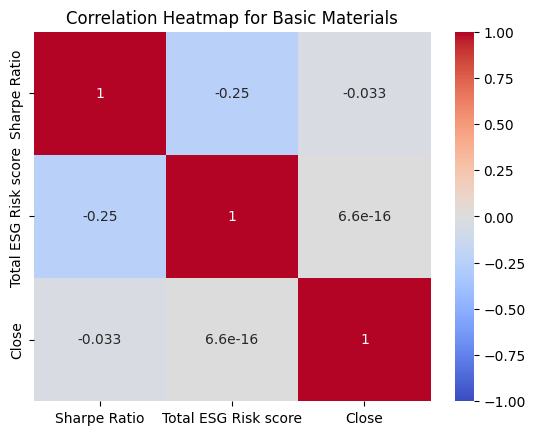

Correlation Matrix for Sector: Communication Services
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000          5.495482e-01  1.086040e-02
Total ESG Risk score      0.549548          1.000000e+00  5.407092e-18
Close                     0.010860          5.407092e-18  1.000000e+00



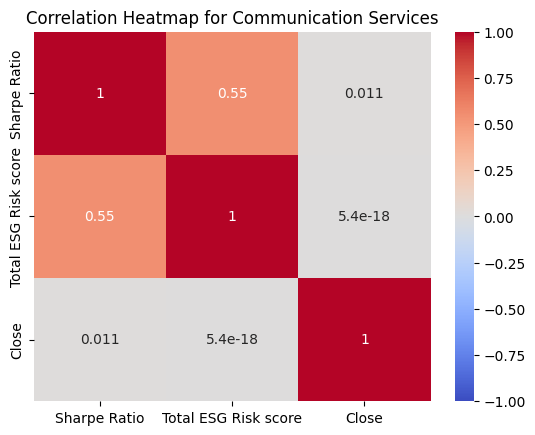

Correlation Matrix for Sector: Consumer Cyclical
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -1.361673e-01 -1.638893e-02
Total ESG Risk score     -0.136167          1.000000e+00 -1.555701e-16
Close                    -0.016389         -1.555701e-16  1.000000e+00



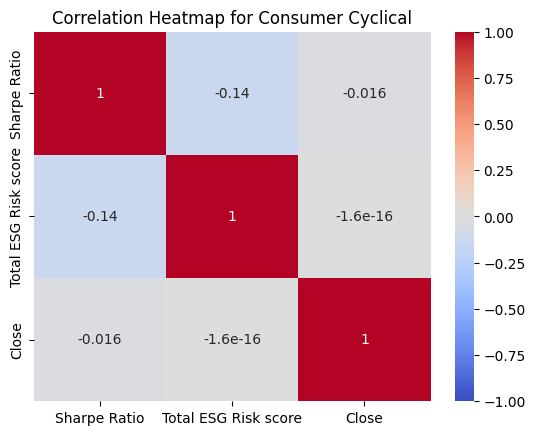

Correlation Matrix for Sector: Consumer Defensive
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -2.268399e-01 -9.037992e-03
Total ESG Risk score     -0.226840          1.000000e+00 -4.095521e-16
Close                    -0.009038         -4.095521e-16  1.000000e+00



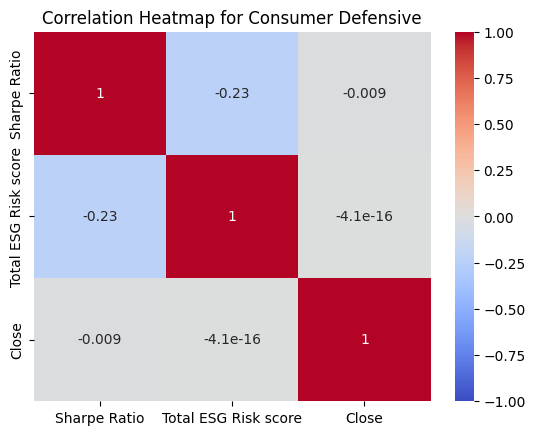

Correlation Matrix for Sector: Energy
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000          4.596997e-01 -9.908678e-02
Total ESG Risk score      0.459700          1.000000e+00  1.671217e-16
Close                    -0.099087          1.671217e-16  1.000000e+00



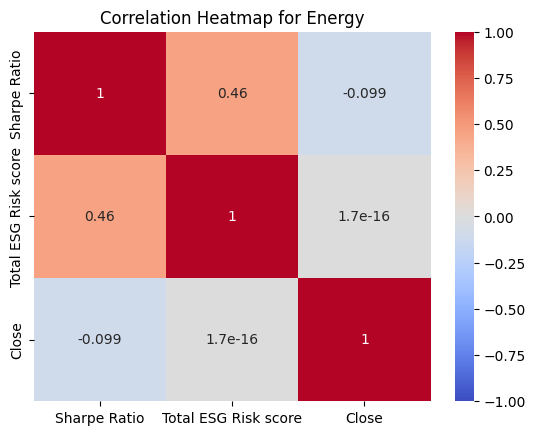

Correlation Matrix for Sector: Financial Services
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -2.887162e-01 -2.410480e-02
Total ESG Risk score     -0.288716          1.000000e+00 -2.181500e-16
Close                    -0.024105         -2.181500e-16  1.000000e+00



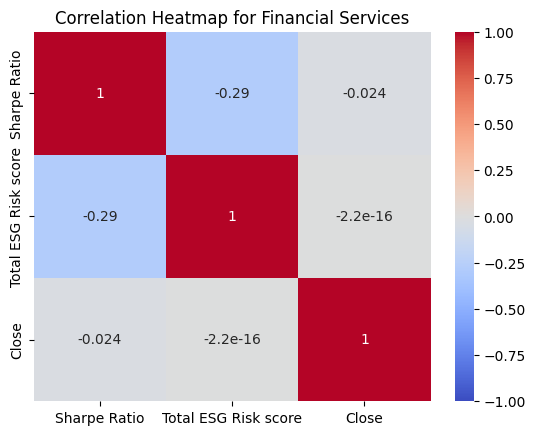

Correlation Matrix for Sector: Healthcare
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -1.722519e-02 -1.441331e-02
Total ESG Risk score     -0.017225          1.000000e+00 -4.819353e-16
Close                    -0.014413         -4.819353e-16  1.000000e+00



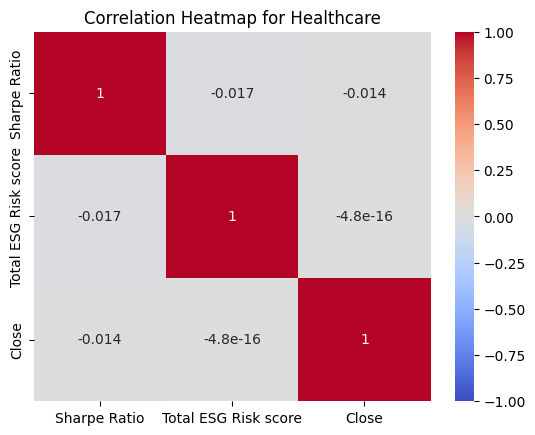

Correlation Matrix for Sector: Industrials
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -2.590394e-01 -1.959819e-02
Total ESG Risk score     -0.259039          1.000000e+00 -1.448248e-16
Close                    -0.019598         -1.448248e-16  1.000000e+00



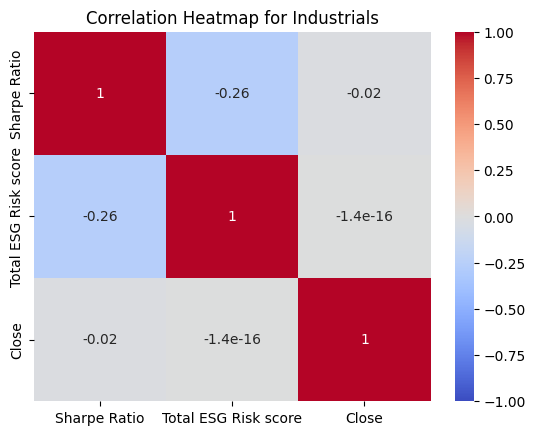

Correlation Matrix for Sector: Real Estate
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000          8.430000e-02 -2.210319e-02
Total ESG Risk score      0.084300          1.000000e+00  5.544920e-16
Close                    -0.022103          5.544920e-16  1.000000e+00



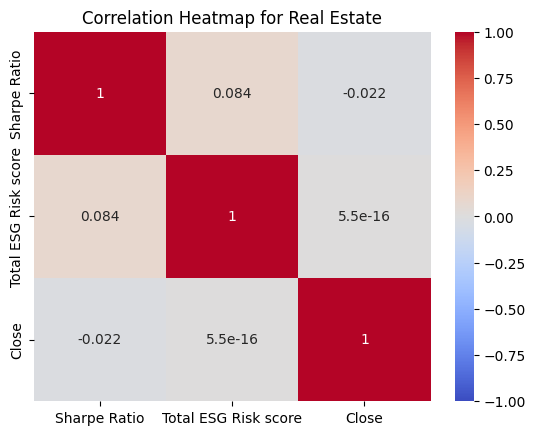

Correlation Matrix for Sector: Technology
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -9.415142e-02 -1.546894e-02
Total ESG Risk score     -0.094151          1.000000e+00 -6.805828e-16
Close                    -0.015469         -6.805828e-16  1.000000e+00



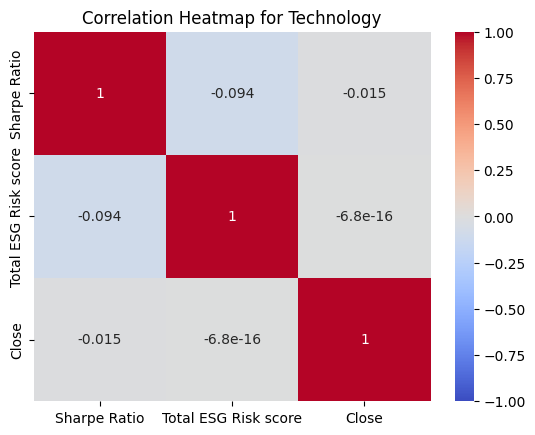

Correlation Matrix for Sector: Utilities
                      Sharpe Ratio  Total ESG Risk score         Close
Sharpe Ratio              1.000000         -7.051206e-02  3.385289e-03
Total ESG Risk score     -0.070512          1.000000e+00  7.413961e-16
Close                     0.003385          7.413961e-16  1.000000e+00



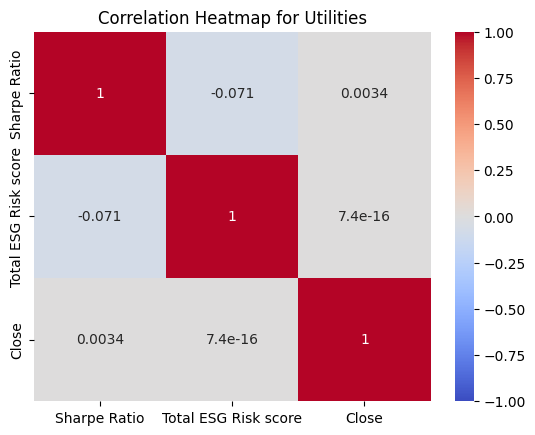

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

sector_groups = df.groupby('Sector')

for sector, group_data in sector_groups:
    # Select columns for correlation
    subset = group_data[['Sharpe Ratio', 'Total ESG Risk score', 'Close']]
    
    # Drop rows with missing values to avoid NaNs in the correlation
    subset = subset.dropna()
    
    if len(subset) < 2:
        continue  # Skip if there's not enough data
    
    corr_matrix = subset.corr()
    print(f"Correlation Matrix for Sector: {sector}")
    print(corr_matrix)
    print()

    # Optionally visualize
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap for {sector}")
    plt.show()


In [104]:
# Segment companies by ESG quartiles
df['ESG_quartile'] = pd.qcut(df['Total ESG Risk score'], 4, labels=['Q1','Q2','Q3','Q4'])

# Group by ESG quartile and maybe further by VIX_bin if you want
grouped_quartiles = df.groupby(['Sector', 'ESG_quartile', 'VIX_bin'])

summary = grouped_quartiles['Sharpe Ratio'].mean().reset_index()

print(summary.head(10))  # Inspect the first few rows


            Sector ESG_quartile       VIX_bin  Sharpe Ratio
0  Basic Materials           Q1       Low Vol      0.416500
1  Basic Materials           Q1   Med-Low Vol      0.415640
2  Basic Materials           Q1  Med-High Vol      0.412217
3  Basic Materials           Q1      High Vol      0.414660
4  Basic Materials           Q2       Low Vol      0.346594
5  Basic Materials           Q2   Med-Low Vol      0.337493
6  Basic Materials           Q2  Med-High Vol      0.338044
7  Basic Materials           Q2      High Vol      0.351080
8  Basic Materials           Q3       Low Vol      0.278506
9  Basic Materials           Q3   Med-Low Vol      0.265813


/var/folders/40/s6qykty12fdcmr7sw5h2nvz00000gn/T/ipykernel_5839/748961528.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_quartiles = df.groupby(['Sector', 'ESG_quartile', 'VIX_bin'])


In [105]:
risk_ratings_df = pd.read_csv("./SP 500 ESG Risk Ratings.csv")
risk_ratings_df

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Level,Controversy Score,ESG Risk Percentile,ESG Risk Level
0,ENPH,"Enphase Energy, Inc.","47281 Bayside Parkway\nFremont, CA 94538\nUnit...",Technology,Solar,"3,157","Enphase Energy, Inc., together with its subsid...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,"14,000",Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,Moderate Controversy Level,2.0,50th percentile,Medium
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,"6,500","Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,Moderate Controversy Level,2.0,66th percentile,Medium
3,DAY,"Dayforce, Inc.","3311 East Old Shakopee Road\nMinneapolis, MN 5...",Technology,Software - Application,"9,084","Dayforce Inc., together with its subsidiaries,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,"70,000",DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,Moderate Controversy Level,2.0,38th percentile,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,ACN,Accenture Plc,1 Grand Canal Square\nGrand Canal Harbour\nDub...,Technology,Information Technology Services,"742,000","Accenture plc, a professional services company...",9.8,0.8,4.4,4.6,Moderate Controversy Level,2.0,3rd percentile,Negligible
499,ABBV,Abbvie Inc.,"1 North Waukegan Road\nNorth Chicago, IL 60064...",Healthcare,Drug Manufacturers - General,"50,000","AbbVie Inc. discovers, develops, manufactures,...",29.9,2.4,10.4,17.2,Significant Controversy Level,3.0,69th percentile,Medium
500,ABT,Abbott Laboratories,100 Abbott Park Road\nAbbott Park\nNorth Chica...,Healthcare,Medical Devices,"114,000","Abbott Laboratories, together with its subsidi...",24.8,2.3,8.3,14.2,Significant Controversy Level,3.0,48th percentile,Medium
501,AOS,A.O. Smith Corporation,11270 West Park Place\nSuite 170 PO Box 245008...,Industrials,Specialty Industrial Machinery,"12,000",A. O. Smith Corporation manufactures and marke...,25.4,7.2,6.4,11.9,Low Controversy Level,1.0,51st percentile,Medium


In [106]:
sharpe_ratios_df = sharpe_ratios_df.loc[:, ~sharpe_ratios_df.columns.str.contains('^Unnamed')]

sharpe_ratios_df.dropna(how='all', inplace=True)
risk_ratings_df.dropna(how='all', inplace=True)
sharpe_ratios_df = sharpe_ratios_df[~sharpe_ratios_df['Name'].astype(str).str.contains(r'^\t|\n$', na=False)]
risk_ratings_df = risk_ratings_df[~risk_ratings_df['Name'].astype(str).str.contains(r'^\t|\n$', na=False)]

In [107]:
# Convert to datetime values
vix_df['Date'] = pd.to_datetime(vix_df['Date']).dt.to_period('M')
vix_df = vix_df[['Date', 'Close']]

# Convert the date columns to specific dates in the date column
sharpe_ratios_long = sharpe_ratios_df.melt(
    id_vars=['Symbol', 'Name', 'Metrics'], 
    var_name='Date', 
    value_name='Sharpe Ratio'
)
sharpe_ratios_long['Date'] = pd.to_datetime(sharpe_ratios_long['Date'], format='%b %y', errors='coerce').dt.to_period('M')
sharpe_ratios_long = sharpe_ratios_long.dropna(subset=['Date'])

/var/folders/40/s6qykty12fdcmr7sw5h2nvz00000gn/T/ipykernel_5839/2969627071.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vix_df['Date'] = pd.to_datetime(vix_df['Date']).dt.to_period('M')


In [108]:
# Merge Sharpe Ratios with ESG Risk Ratings
merged_data = sharpe_ratios_long.merge(risk_ratings_df, on="Symbol", how="left")

# Merge with VIX data
final_timeseries = merged_data.merge(vix_df, on="Date", how="left")

In [109]:
cols = ["Symbol", "Name_x", "Metrics", "Date", "Sharpe Ratio", "Sector", "Close", "Total ESG Risk score"]
final_timeseries = final_timeseries[cols]

In [110]:
final_timeseries

,Symbol,Name_x,Metrics,Date,Sharpe Ratio,Sector,Close,Total ESG Risk score
0,A,Agilent Technologies Inc,Historical Sharpe Ratio (Since Inception),2023-05,0.1307,Healthcare,17.95,13.6
1,AAPL,Apple Inc,Historical Sharpe Ratio (Since Inception),2023-05,0.3859,Technology,17.95,17.2
2,ABBV,AbbVie Inc,Historical Sharpe Ratio (Since Inception),2023-05,0.7112,Healthcare,17.95,29.9
3,ABNB,Airbnb Inc,Historical Sharpe Ratio (Since Inception),2023-05,-0.2592,Consumer Cyclical,17.95,NaN
4,ABT,Abbott Laboratories,Historical Sharpe Ratio (Since Inception),2023-05,0.5981,Healthcare,17.95,24.8
...,...,...,...,...,...,...,...,...
11083,XYL,Xylem Inc,Historical Sharpe Ratio (Since Inception),2020-05,0.5270,Industrials,27.51,18.1
11084,YUM,Yum Brands Inc,Historical Sharpe Ratio (Since Inception),2020-05,0.4917,Consumer Cyclical,27.51,20.1
11085,ZBH,Zimmer Biomet Holdings Inc,Historical Sharpe Ratio (Since Inception),2020-05,0.2707,Healthcare,27.51,26.0
11086,ZBRA,Zebra Technologies Corp,Historical Sharpe Ratio (Since Inception),2020-05,0.3729,Technology,27.51,NaN


In [111]:
aggregated_timeseries = final_timeseries.groupby('Date').agg({
    'Sharpe Ratio': 'mean',
    'Close': 'mean',
    'Total ESG Risk score': 'mean'
}).reset_index()
aggregated_timeseries.dtypes

Date                    period[M]
Sharpe Ratio              float64
Close                     float64
Total ESG Risk score      float64
dtype: object

In [112]:
# Convert numeric columns to float for proper plotting
aggregated_timeseries['Date'] = aggregated_timeseries['Date'].astype(str)
final_timeseries['Date'] = final_timeseries['Date'].astype(str)


## EDA

In [113]:
print( final_timeseries.describe())

       Sharpe Ratio         Close  Total ESG Risk score
count  10923.000000  11088.000000           9262.000000
mean       0.437227     23.792273             21.486461
std        2.560209      5.586086              6.863033
min       -2.886000     16.260000              7.100000
25%        0.261250     19.400000             16.400000
50%        0.379100     23.790000             21.000000
75%        0.495900     27.190000             25.900000
max      260.070000     38.020000             41.700000


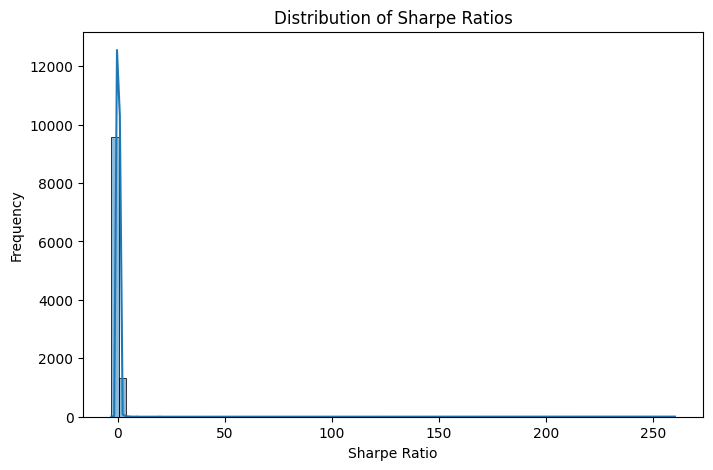

In [114]:
plt.figure(figsize=(8, 5))
sns.histplot(final_timeseries["Sharpe Ratio"], bins=75, kde=True)
plt.title("Distribution of Sharpe Ratios")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Frequency")
plt.show()

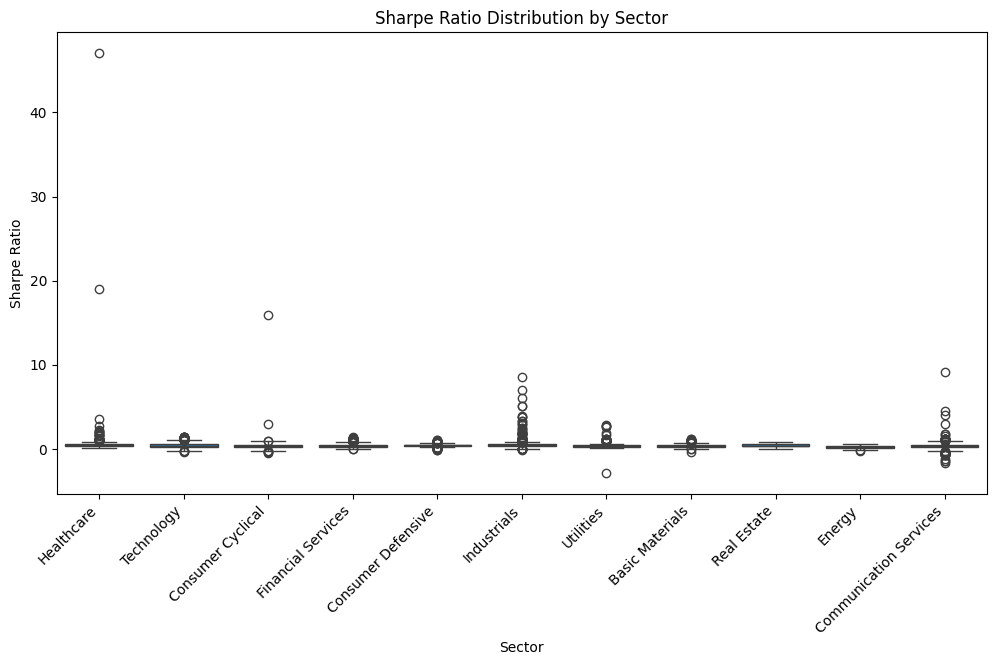

In [115]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_timeseries, x="Sector", y="Sharpe Ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Sharpe Ratio Distribution by Sector")
plt.show()

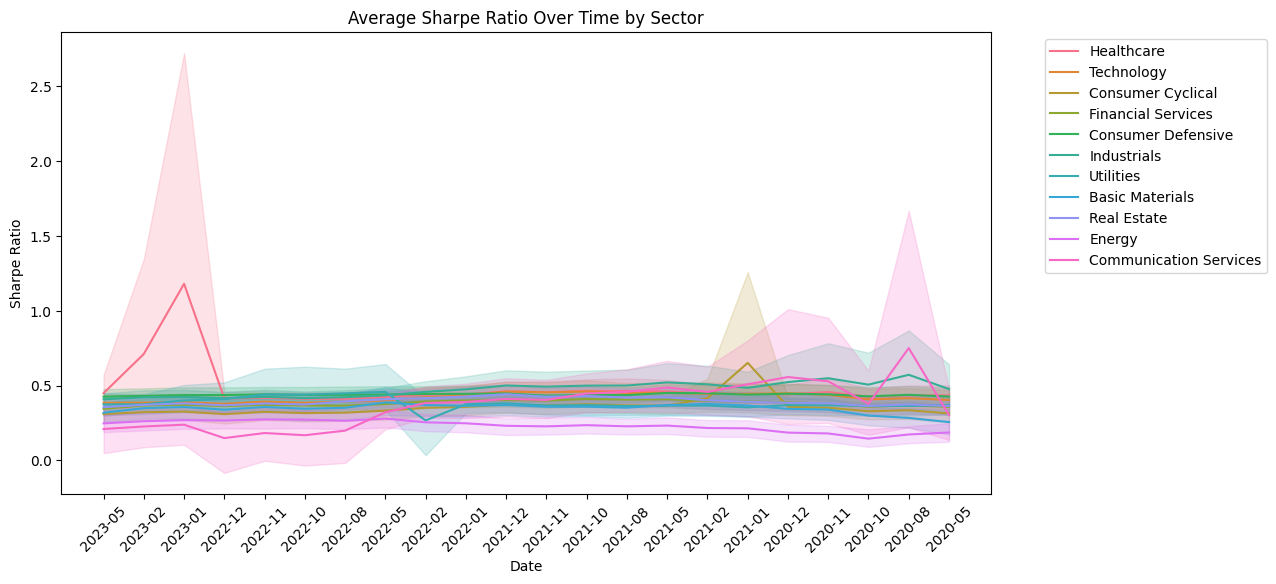

In [116]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_timeseries, x="Date", y="Sharpe Ratio", hue="Sector", estimator="mean")
plt.xticks(rotation=45)
plt.title("Average Sharpe Ratio Over Time by Sector")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

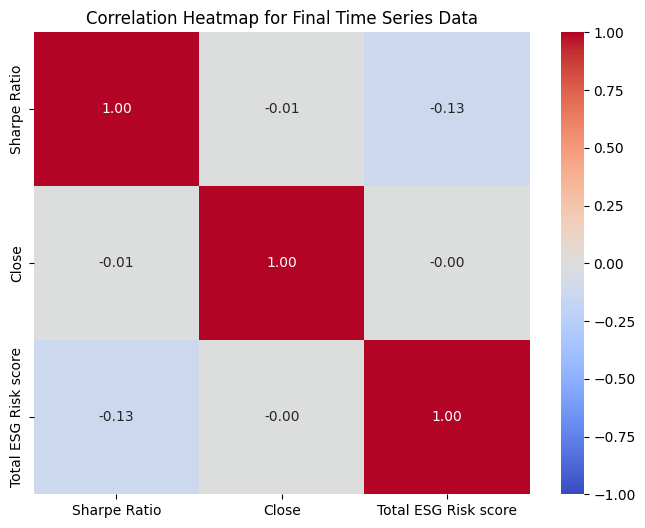

In [117]:
plt.figure(figsize=(8, 6))
sns.heatmap(final_timeseries.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Final Time Series Data")
plt.show()

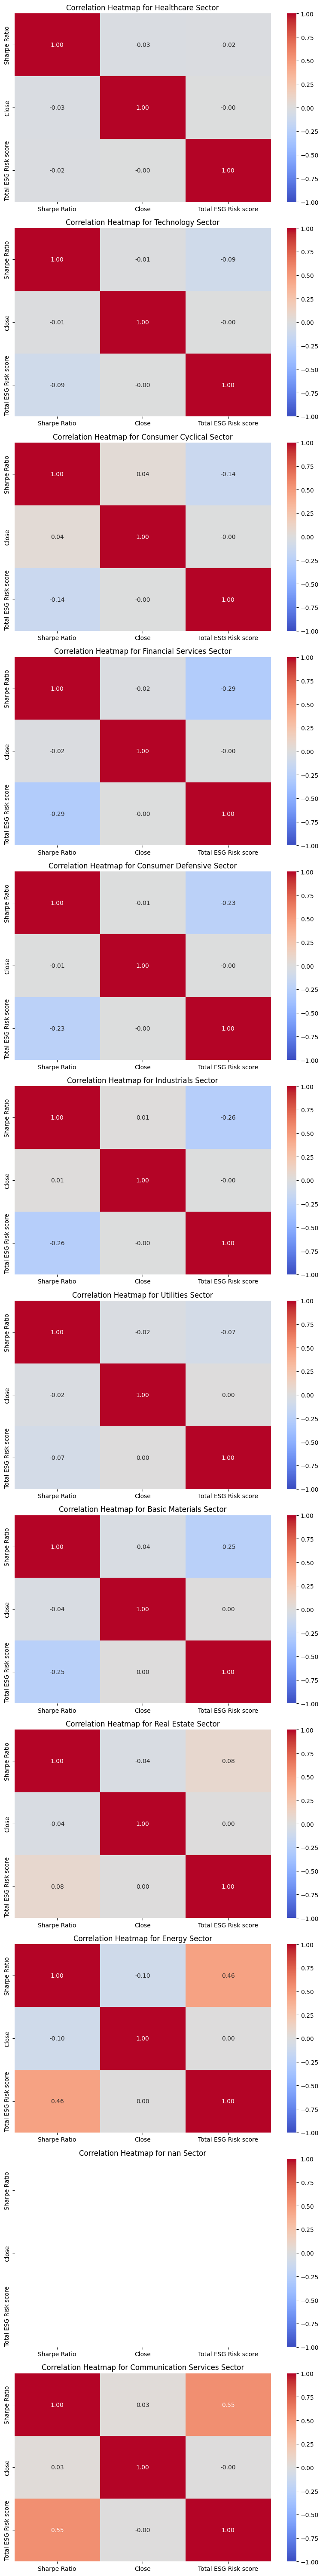

In [118]:
sector_list = final_timeseries["Sector"].unique()
fig, axes = plt.subplots(nrows=len(sector_list), figsize=(8, len(sector_list) * 5))
for i, sector in enumerate(sector_list):
    sector_data = final_timeseries[final_timeseries["Sector"] == sector]

    corr_matrix = sector_data[["Sharpe Ratio", "Close", "Total ESG Risk score"]].corr(numeric_only=True)

    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[i], vmin=-1, vmax=1)
    axes[i].set_title(f"Correlation Heatmap for {sector} Sector")

plt.tight_layout()
plt.show()

In [119]:
print(aggregated_timeseries.describe())

       Sharpe Ratio      Close  Total ESG Risk score
count     22.000000  22.000000          2.200000e+01
mean       0.437323  23.792273          2.148646e+01
std        0.118236   5.717284          3.636318e-15
min        0.367874  16.260000          2.148646e+01
25%        0.384036  19.692500          2.148646e+01
50%        0.419259  23.790000          2.148646e+01
75%        0.433704  26.995000          2.148646e+01
max        0.948431  38.020000          2.148646e+01


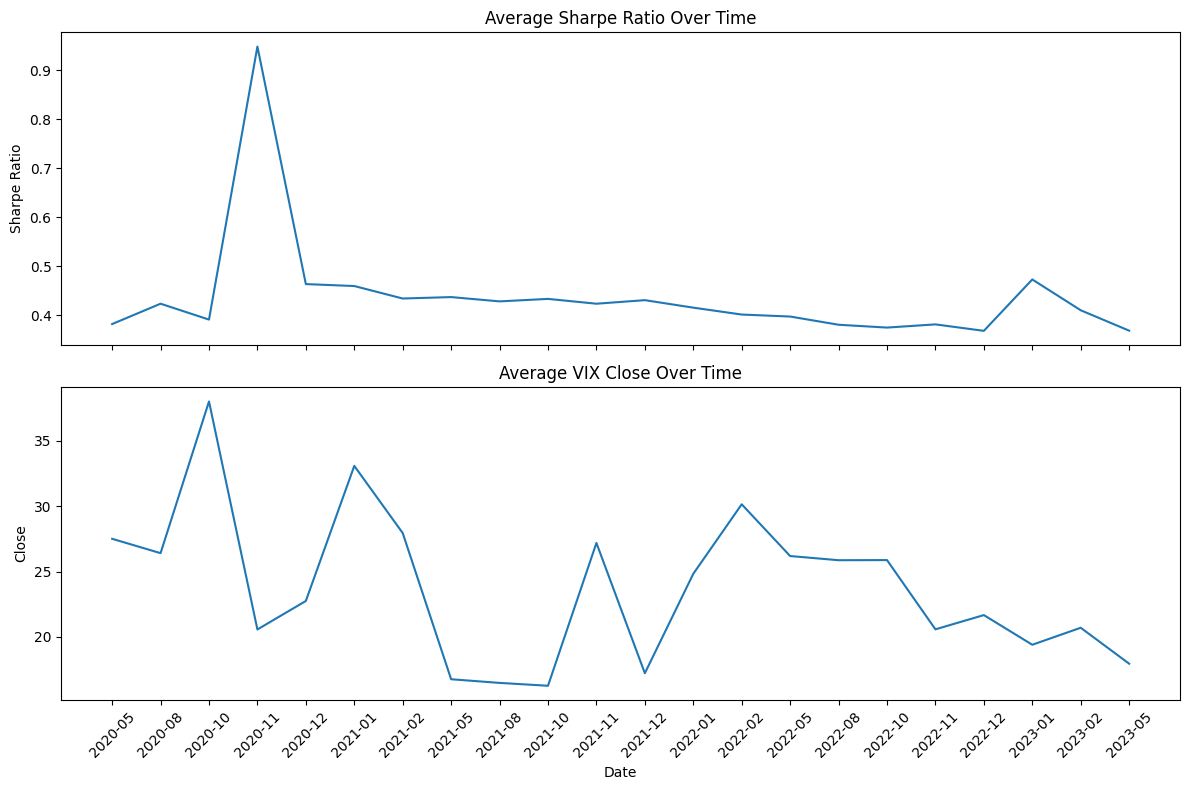

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

sns.lineplot(data=aggregated_timeseries, x="Date", y="Sharpe Ratio", ax=axes[0])
axes[0].set_title("Average Sharpe Ratio Over Time")

# VIX Close Trend
sns.lineplot(data=aggregated_timeseries, x="Date", y="Close", ax=axes[1])
axes[1].set_title("Average VIX Close Over Time")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

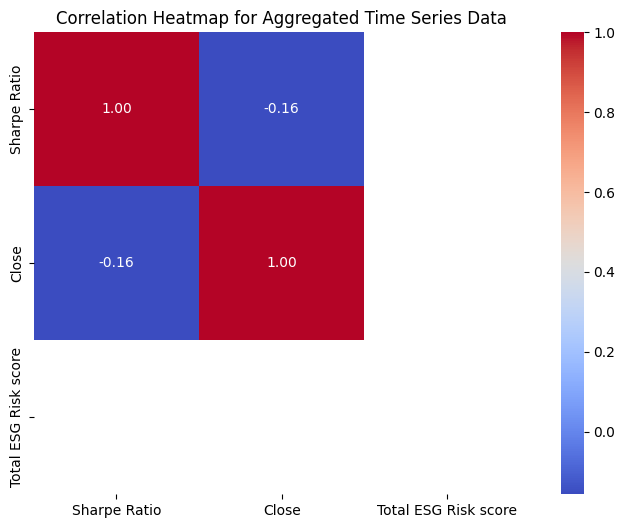

In [121]:
plt.figure(figsize=(8, 6))
sns.heatmap(aggregated_timeseries.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap for Aggregated Time Series Data")
plt.show()